In [1]:
"""Offset and UPDRS correlaiton."""
%load_ext autoreload
%autoreload 2
from analysis_settings import *
from plot_settings import *
from scripts.utils_plot import (explode_df, _save_fig, _add_band,
                                _get_sample_sizes, _get_cohen_stats,
                                _axes2d,
                                convert_pvalue_to_asterisks)
from scipy.stats import wilcoxon
import numpy as np
from scripts.utils_plot import cohen_d, equalize_x_and_y
import pingouin as pg
from scipy.stats import bootstrap
from scripts.utils import _average_hemispheres
from pte_stats import cluster, timeseries

In [2]:
# n_perm = int(1e2)
n_perm = int(1e4)  # cluster stats
n_boot = 10000  # cohen's d
# n_perm = int(1e6)  # imporant to avoid false positive alpha cluster periodic

In [3]:
sns.set_style('darkgrid')
ch_choice = 'ch_dist_sweet'
dataframes = get_dfs(ch_choice, equalize_subjects_norm_abs=False)

bbox_inches = None  # important to get correct figure size output
tight_layout = True  # important to fill whole figure
estimator = 'effect_size'  # mean and median also implemented

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sub_hemi_cond'] = df.sub_hemi + '_' + df.cond
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot['UPDRS_exists'] = pivot.UPDRS_bradyrigid_contra.notna()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:82: 

# Functions

In [4]:
def _extract_arrays(df1, df2, x, y, x_max, x_min):
    if 'fm' in x:
        # different projects have different fitting ranges
        cond_arr1 = []
        for _, row1 in df1.iterrows():
            if np.isnan(row1[y]).any():
                raise ValueError(f"NaNs should not be present")
                # continue
            times = row1[x]
            # assert row2[x].all() == times.all()
            x_mask = (times >= x_min) & (times <= x_max)
            times = times[x_mask]
            cond_arr1.append(row1[y][x_mask])
        # use a separate loop since df1 and df2 can have different lengths
        # for non-paired statistics
        cond_arr2 = []
        for _, row2 in df2.iterrows():
            if np.isnan(row2[y]).any():
                raise ValueError(f"NaNs should not be present")
                # continue
            times = row2[x]
            # assert row2[x].all() == times.all()
            x_mask = (times >= x_min) & (times <= x_max)
            times = times[x_mask]
            cond_arr2.append(row2[y][x_mask])

        x_arr = np.stack(cond_arr1).T
        y_arr = np.stack(cond_arr2).T
    else:
        times = df1[x].values[0]
        x_mask = (times >= x_min) & (times <= x_max)
        times = times[x_mask]

        x_arr = np.stack(df1[y].values)[:, x_mask].T
        y_arr = np.stack(df2[y].values)[:, x_mask].T
    return x_arr, y_arr, times


def _get_clusters(x1, x2, times, alpha_sig=0.05, n_perm=100000,
                  paired_x1x2=True):
    cluster_times = []
    two_tailed = True
    one_tailed_test = 'larger'
    min_cluster_size = 2
    if paired_x1x2:
        data_a = x1 - x2
        data_b = 0.0
    else:
        data_a = x1
        data_b = x2
    if not two_tailed and one_tailed_test == "smaller":
        data_a_stat = data_a * -1
    else:
        data_a_stat = data_a

    p_vals = timeseries.timeseries_pvals(
            x=data_a_stat, y=data_b, n_perm=n_perm, two_tailed=two_tailed)
    clusters, cluster_count = cluster.clusters_from_pvals(
            p_vals=p_vals, alpha=alpha_sig, correction_method='cluster_pvals',
            n_perm=n_perm, min_cluster_size=min_cluster_size)

    x_labels = times.round(2)
    cluster_vals = []
    for cluster_idx in range(1, cluster_count + 1):
        index = np.where(clusters == cluster_idx)[0]
        if index.size == 0:
            # print("No clusters found.")
            continue
        lims = np.arange(index[0], index[-1] + 1)
        time_0 = x_labels[lims[0]]
        time_1 = x_labels[lims[-1]]
        # print(f"Cluster found between {time_0} Hz and" f" {time_1} Hz.")
        cluster_times.append((time_0, time_1))
        cluster_vals.append(data_a_stat[lims].mean())
    cluster_borders = np.array(cluster_times)
    return clusters, cluster_count, cluster_borders, cluster_vals


def _plot_clusters(ax, x1, x2, times, clusters, cluster_count,
                   alpha=0.05, color_cluster='k', alpha_plot=.2):

    if isinstance(x2, (int, float)):
        y_arr = np.ones((x1.shape[0], 1))
        y_arr[:, 0] = x2
    else:
        y_arr = x2
    x_arr = x1
    label = f"p ≤ {alpha}"
    for cluster_idx in range(1, cluster_count + 1):
        index = np.where(clusters == cluster_idx)[0]
        if index.size == 0:
            # print("No clusters found.")
            continue
        lims = np.arange(index[0], index[-1] + 1)
        y1 = x_arr.mean(axis=1)[lims]
        y2 = y_arr.mean(axis=1)[lims]
        ax.fill_between(x=times[lims], y1=y1, y2=y2, alpha=alpha_plot,
                        color=color_cluster, label=label)


def _plot_clusters_line(ax, times, clusters, cluster_count, height, color):
    for cluster_idx in range(1, cluster_count + 1):
        index = np.where(clusters == cluster_idx)[0]
        if index.size == 0:
            # print("No clusters found.")
            continue
        lims = np.arange(index[0], index[-1] + 1)
        y_arr = np.ones((times[lims].shape[0], 1)) * height
        ax.plot(times[lims], y_arr, color=color, lw=.5)


# def _plot_clusters_rect(ax, times, clusters, cluster_count,
#                         # color
#                         ):
#     for cluster_idx in range(1, cluster_count + 1):
#         index = np.where(clusters == cluster_idx)[0]
#         if index.size == 0:
#             print("No clusters found.")
#             continue
#         lims = np.arange(index[0], index[-1] + 1)
#         y_arr = np.ones((times[lims].shape[0], 1)) * 0.02
#         ax.plot(times[lims], y_arr,
#                 color='k',
#                 lw=1
#                 )

In [5]:
def _plot_clusters(ax, x1, x2, times, clusters, cluster_count,
                   alpha=0.05, color_cluster='k', alpha_plot=.2):

    if isinstance(x2, (int, float)):
        y_arr = np.ones((x1.shape[0], 1))
        y_arr[:, 0] = x2
    else:
        y_arr = x2
    x_arr = x1
    label = f"p ≤ {alpha}"
    for cluster_idx in range(1, cluster_count + 1):
        index = np.where(clusters == cluster_idx)[0]
        if index.size == 0:
            # print("No clusters found.")
            continue
        lims = np.arange(index[0], index[-1] + 1)
        y1 = x_arr.mean(axis=1)[lims]
        y2 = y_arr.mean(axis=1)[lims]
        ax.fill_between(x=times[lims], y1=y1, y2=y2, alpha=alpha_plot,
                        color=color_cluster, label=label)


def _plot_clusters_line(ax, times, clusters, cluster_count, height, color):
    for cluster_idx in range(1, cluster_count + 1):
        index = np.where(clusters == cluster_idx)[0]
        if index.size == 0:
            # print("No clusters found.")
            continue
        lims = np.arange(index[0], index[-1] + 1)
        y_arr = np.ones((times[lims].shape[0], 1)) * height
        ax.plot(times[lims], y_arr, color=color, lw=.5)


# def _plot_clusters_rect(ax, times, clusters, cluster_count,
#                         # color
#                         ):
#     for cluster_idx in range(1, cluster_count + 1):
#         index = np.where(clusters == cluster_idx)[0]
#         if index.size == 0:
#             print("No clusters found.")
#             continue
#         lims = np.arange(index[0], index[-1] + 1)
#         y_arr = np.ones((times[lims].shape[0], 1)) * 0.02
#         ax.plot(times[lims], y_arr,
#                 color='k',
#                 lw=1
#                 )

In [6]:
def _mean_psds_ax(ax, df_proj, x, y, kind, hue,
                  add_bands=False, scale='log', fm_params=False,
                  n_perm=10000, paired=True,
                  palette=None, xmin=2, xmax=45):
    proj = df_proj.project.unique()[0]
    proj_nme = df_proj.project_nme.unique()[0]

    if hue == 'cond':
        hue_order = ['off', 'on']
        df_proj = df_proj[df_proj[hue].isin(hue_order)]
        if palette is None:
            palette = [cfg.COLOR_DIC[proj], cfg.COLOR_DIC[proj + "2"]]
        else:
            palette = [cfg.COLOR_DIC[kind], cfg.COLOR_DIC[kind + '2']]
        style = style_order = None
        keep_cols = ['fm_params']
        if kind == 'normalized':
            height = 0.1
        else:
            height = -.01
    elif hue.endswith('_severity_median'):
        assert df_proj.cond.nunique() == 1, "Don't mix conds"
        if hue == 'UPDRS_III_severity_median':
            # average hemispheres
            group = df_proj.groupby(['subject'])
            df_proj.loc[:, x] = group[x].transform("mean")
            df_proj.loc[:, y] = group[y].transform("mean")
            df_proj = df_proj.drop_duplicates(subset=["subject"])
            sampling = 'patients'
        elif hue == 'UPDRS_bradyrigid_contra_severity_median':
            sampling = 'STNs'
        n_mild = df_proj[df_proj[hue] == 'mild_half'].shape[0]
        n_severe = df_proj[df_proj[hue] == 'severe_half'].shape[0]
        sample_size_mild = f'(n={n_mild})'
        sample_size_severe = f'(n={n_severe})'
        mild_nme = f'Mild {sampling} {sample_size_mild}'
        severe_nme = f'Severe {sampling} {sample_size_severe}'
        rename = {'mild_half': mild_nme, 'severe_half': severe_nme}
        hue_order = [severe_nme, mild_nme]
        style = hue
        style_order = hue_order
        keep_cols = ['fm_params', hue]
        # df_proj.loc[:, hue] = df_proj[hue].astype('category')
        # df_proj.loc[:, hue] = df_proj[hue].cat.add_categories("Unknown")
        # df_proj.loc[:, hue] = df_proj[hue].fillna("Unknown")  # Replace NaN with a placeholder if needed
        # df_proj.loc[:, hue] = df_proj[hue].astype('category')
        df_proj.loc[:, hue] = df_proj[hue].cat.rename_categories(rename)
        df_proj.loc[:, hue] = df_proj[hue].cat.remove_unused_categories()
        df_proj = df_proj[df_proj[hue].isin(hue_order)]
        height = -.01

    df_psd = explode_df(df_proj, freqs=x, psd=y, fm_params=fm_params,
                        keep_cols=keep_cols, fmin=xmin, fmax=xmax)

    sns.lineplot(data=df_psd, ax=ax, x=x, y=y, hue=hue, palette=palette,
                 hue_order=hue_order, style=style, style_order=style_order,
                 errorbar=CI_SPECT)
    handles, labels = ax.get_legend_handles_labels()
    if labels[0] in cfg.PLOT_LABELS:
        labels = [cfg.PLOT_LABELS[label] for label in labels]

    # Cluster statistics

    # Extract cluster varible
    cluster_conds = df_proj[hue].unique()
    assert len(cluster_conds) == 2, f'Only two conds supported got {cluster_conds}'

    df1 = df_proj[df_proj[hue] == cluster_conds[0]]
    df2 = df_proj[df_proj[hue] == cluster_conds[1]]

    if paired:
        assert (df1.subject.to_numpy() == df2.subject.to_numpy()).all()
        assert (df1.subject.values == df2.subject.values).all()

    # xmin, xmax = df_proj[x].min(), df_proj[x].max()
    x_array, y_array, times = _extract_arrays(df1, df2, x, y, xmax, xmin)

    clusters, cluster_count, cluster_borders, cluster_vals = _get_clusters(
            x_array, y_array, times, n_perm=n_perm, paired_x1x2=paired)

    ldopa_enhanced_clusters = []
    ldopa_reduced_clusters = []
    for idx, border in enumerate(cluster_borders):
        if cluster_vals[idx] > 0:
            ldopa_reduced_clusters.append(border)
        elif cluster_vals[idx] < 0:
            ldopa_enhanced_clusters.append(border)
        else:
            raise ValueError("Cluster value should not be zero")
    print('\n')
    print(f'{proj_nme} clusters:\n')
    print(f'Enhanced:')
    for cluster in ldopa_enhanced_clusters:
        print(f'{cluster[0]:.0f}-{cluster[1]:.0f} Hz')
    print('\n')
    print(f'Reduced:')
    for cluster in ldopa_reduced_clusters:
        print(f'{cluster[0]:.0f}-{cluster[1]:.0f} Hz')
    print('\n')

    _plot_clusters_line(ax, times, clusters, cluster_count, height, palette[0])

    if proj == 'Neumann' or kind in ['absolute', 'periodic', 'lorentzian']:
        if scale == 'linear':
            if kind in ['normalized', 'relative']:
                ylabel = "Normalized spectra\n[%]"
            else:
                ylabel = 'Spectra\n'r'[$\mu V^2/Hz$]'
        else:
            if kind in ['normalized', 'relative']:
                ylabel = "Normalized spectra\n[log10(%)]"
            else:
                ylabel = 'Spectra\n'r'[$log10(\mu V^2/Hz)$]'
    else:
        ylabel = None
    _add_band(add_bands, ax)
    # hemi_off, hemi_on, hemi_both = _get_sample_sizes(df_proj, proj, 'cond', y)
    # df_mean = _average_hemispheres(df_proj, x, y)
    # sub_off, sub_on, sub_both = _get_sample_sizes(df_mean, proj, 'cond', y)

    # Legend entries
    # labels = [f"off (n={hemi_off})", f"on (n={hemi_on})"]
    # labels = [r'off ($n_{\mathrm{hemi}}$='f"{hemi_off}",
    #           r'on ($n_{\mathrm{hemi}}$='f"{hemi_on}"]
    # labels = ['off', 'on']
    # legend_title = r"$n_{\mathrm{hemi}}=$"f"{hemi_both}" if legend_title else None
    # legend_title = None
    # ax.legend(handles, labels, loc='upper right', title=legend_title,
    #         handlelength=1)
    if proj == 'all' or kind in ['normalized', 'relative']:
        ax.legend(handles, labels, loc='upper right', title=None,
                handlelength=1)
    else:
        ax.get_legend().remove()
    ax.set_ylabel(ylabel)
    # project_nme = cfg.PROJECT_DICT[proj]
    # sample_size_detailed = (r' ($n_{\mathrm{hemi}}$='f"{hemi_both}, "
    #                         r'$n_{\mathrm{sub}}$='f"{sub_both})")
    # subject_max = r' ($n_{\mathrm{sub}}$='f"{max(sub_off, sub_on)})"
    # if kind in ['normalized', 'relative']:
    #     title = project_nme + subject_max
    # else:
    #     # title = project_nme
    #     title = None
    # title = project_nme  #  + sample_size_detailed
    # ax.set_title(title, color=palette[0])
    if scale == 'linear':
        if kind in ['normalized', 'relative']:
            ylim = (0, 10)
        else:
            ylim = (-.02, 1.2)
    # elif scale == 'log':
    #     if kind in ['normalized', 'relative']:
    #         ylim = (-.6, 1)
    #     elif kind == 'absolute':
    #         ylim = (-1.8, 0)
    #     elif kind == 'periodic':
    #         ylim = (0, .6)
    ax.set_ylim(ylim)
    # if proj == 'all':
    #     _add_band_annotations(BANDS, ax)
    # ax.set_xlim(xlim)
    # ax.set_xticks(xticks)
    ax.set_xticks(XTICKS_FREQ_low)
    ax.set_xticklabels(XTICKS_FREQ_low_labels)
    # ax.set_xlim(band_borders[0], band_borders[-1])
    buffer = .2
    ax.set_xlim(XTICKS_FREQ_low[0] - buffer, XTICKS_FREQ_low[-1] + buffer)

    # if not xticklabels:
    #     ax.set_xticklabels([])
    ax.spines['top'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    # ax.set_xlim(0, XTICKS_FREQ[-1])
    ax.tick_params(top=False, labeltop=False, bottom=False, labelbottom=False)
    # ax.set_yticks([0, 3, 6])
    return df_proj, hue_order


def _get_wilcoxon_stats(df_diff, ycols, multiple_comparison=True):
    p_values = []
    for y in ycols:
        xy_diff = df_diff[y].dropna().to_numpy()
        pvalue = wilcoxon(xy_diff).pvalue

        if multiple_comparison:
            pvalue /= len(ycols)
        p_values.append(pvalue)
    return p_values


def _annotate_wilcoxon(ax, p_values, bands):
    y_wil = .8  # hard coded
    for i in range(len(p_values)):
        p_value = p_values[i]
        band_middle = np.mean(cfg.BANDS[bands[i]])
        anno_wil = convert_pvalue_to_asterisks(p_value)
        ax.text(band_middle, y_wil, anno_wil, ha='center',
                fontsize=FONTSIZE_ASTERISK, color='k')


def _forrest_plot_ax(ax, df_proj, kind, hue, bands=BANDS, estimator='effect_size',
                     add_band_colors=False, scale='log', hue_order=None,
                     paired=True, ylabel=True,
                     n_boot=10000, palette=None):
    proj = df_proj.project.unique()[0]
    proj_nme = df_proj.project_nme.unique()[0]

    # if hue == 'cond':
    #     hue_order = ['off', 'on']

    # elif hue == 'UPDRS_III_severity_median':
    #     assert df_proj.cond.nunique() == 1, "Don't mix conds"
    #     sampling = 'patients'
    #     # rename = {'mild_half': f'Mild {sampling}',
    #     #         'severe_half': f'Severe {sampling}'}
    #     hue_order = [f'Severe {sampling}', f'Mild {sampling}']

    df_proj = df_proj[df_proj[hue].isin(hue_order)]
    assert df_proj[hue].nunique() == 2, 'Effect size requires two conds'

    # get power columns and band means
    if kind in ['normalized', 'absolute']:
        # pwr = '_abs_max_log'
        pwr = '_abs_mean_log'
    elif kind in ['periodic', 'lorentzian']:
        # pwr = '_fm_powers_log_max'
        pwr = '_fm_mean_log'

    if scale == 'linear':
        pwr = pwr.replace('_log', '')

    band_borders = []
    band_means = []
    values = []
    errors = []
    significances = []
    # pvalues = []
    print(f'{proj_nme} {estimator}:\n')
    for band in bands:
        pwr_col = band + pwr
        if band == 'gamma_broad':
            # don't plot gamma outside of plotting range
            band_border = (cfg.BANDS[band][0], 45)
        else:
            band_border = cfg.BANDS[band]
        band_borders.extend(band_border)
        band_means.append(np.mean(band_border))

        # if paired:
        #     # smaller sample size but stronger statistics
        #     df, n_hemi = equalize_x_and_y(df, 'cond', pwr_col)
        # else:
        #     n_hemi = df.sub_hemi.nunique()
        arr1 = df_proj[df_proj[hue] == hue_order[0]][pwr_col].values
        arr2 = df_proj[df_proj[hue] == hue_order[1]][pwr_col].values
        nx = len(arr1)
        ny = len(arr2)
        if estimator == 'effect_size':
            value = cohen_d(arr1, arr2)
            if np.all(arr1 == 0) or np.all(arr2 == 0):
                # effect size unreasonable if all values are zero
                value = np.nan
            data = (arr1, arr2)
            func = cohen_d
        else:
            if estimator == 'mean':
                func = np.mean
            elif estimator == 'median':
                func = np.median
            else:
                raise ValueError('Unknown estimator')
            value = func(arr1 - arr2)
            data = (arr1 - arr2,)
        print(f'{band}: {value:.2f}')
        values.append(value)
        # pvalue in combination with ci misleading since mixing different stats
        # pvalue = wilcoxon(arr1 - arr2).pvalue
        if n_boot is None:
            assert estimator == 'effect_size', 'Only effect size supports parametric'
            # parametric (fast but more assumptions)
            ci = pg.compute_esci(value, nx, ny, paired=paired)
        else:
            # nonparametric (slow but more correct)
            result = bootstrap(data, func, n_resamples=n_boot, paired=paired,
                               random_state=1)
            ci = result.confidence_interval
            # if distribution is degenerate (many 0 values), apply parametric
            if np.any(np.isnan(result.bootstrap_distribution)):
                ci = pg.compute_esci(value, nx, ny, paired=paired)

        # CIs
        ci_lower, ci_upper = ci
        # error = [[value - ci_lower], [ci_upper - value]]
        error = [[abs(value - ci_lower)], [abs(ci_upper - value)]]
        errors.append(error)
        # if ci_lower < 0 < ci_upper:
        #     significant = False
        # else:
        #     significant = True
        # make sure that np.nan values are not significant
        if value is np.nan:
            significant = False
        elif ci_lower < 0 and ci_upper < 0 or ci_lower > 0 and ci_upper > 0:
            significant = True
        else:
            significant = False
        significances.append(significant)
        # pvalues.append(pvalue)
        # print(f'Project: {proj}, {band} p-value: {pvalue:.2f}')

    # Plot CIs
    # yerr = np.array(errors).reshape(2, len(bands))
    yerr = np.array(errors).reshape(len(bands), 2).T
    if palette is None:
        color = cfg.COLOR_DIC[proj]
    else:
        color = palette[0]
    ax.errorbar(band_means, values, yerr=yerr,
                color=color,  # looks much better than 'k'
                ls='',  # do not plot connecting lines
                markersize=0, capsize=0)
    # Plot markers - looks bad, hard to understand what is CI and what is sample size
    # markersize = n / 20
    # ax.plot(band_means, values, '_', color='k', markersize=markersize)

    # Plot effect sizes as bars
    values = np.repeat(values, 2)  # duplicate values for bars
    ax.plot(band_borders, values, c='k', lw=LINEWIDTH_AXES)
    for band_border, effect_size in zip(band_borders, values):
        ax.vlines(band_border, 0, effect_size, color='k', lw=LINEWIDTH_AXES)
    for j in range(0, len(values)-1, 2):
        border1 = band_borders[j]
        border2 = band_borders[j + 1]
        effect1 = values[j]
        effect2 = values[j + 1]
        borders = [border1, border2]
        effects = [effect1, effect2]
        band = BANDS[j//2]
        if add_band_colors:
            color = cfg.BAND_COLORS[band] if proj == 'all' else 'grey'
        else:
            color = 'grey'
        ax.fill_between(borders, effects, color=color, alpha=.4)
    for j, sig in enumerate(significances):
        if sig:
            display_coords = ax.transData.transform((band_means[j], 0))
            axes_coords = ax.transAxes.inverted().transform(display_coords)
            x_pos = axes_coords[0]
            # convert pval to asterisk
            # asterisk = convert_pvalue_to_asterisks(pval)
            ax.text(x_pos, .927, '*', ha='center',
                    transform=ax.transAxes,
                    fontsize=FONTSIZE_ASTERISK, color='k')

    ax.axhline(0, color="k", lw=LINEWIDTH_AXES)

    # set axis
    if hue == 'cond':
        if proj != 'all':
            ax.set_xticks(XTICKS_FREQ_low[:-1], labels=XTICKS_FREQ_low_labels[:-1])
            xmax = XTICKS_FREQ_low[-1]
        elif proj == 'all':
            ax.set_xticks(XTICKS_FREQ_low, labels=XTICKS_FREQ_low_labels)
            xmax = XTICKS_FREQ_low[-1]
    else:
        ax.set_xticks(XTICKS_FREQ_low, labels=XTICKS_FREQ_low_labels)
        xmax = XTICKS_FREQ_low[-1]
    xmin = XTICKS_FREQ_low[0]
    # add tiny buffer to exactly match white grid line to plot border
    buffer = 0.09
    xmin -= buffer
    xmax += buffer
    ax.set_xlim(xmin, xmax)
        # ax.set_xlim([XTICKS_FREQ_low[0], XTICKS_FREQ_low[-1]])
    # elif hue != 'cond':
    #     if proj != 'all':
    #         ax.set_xticks(XTICKS_FREQ_low[:-1], labels=XTICKS_FREQ_low_labels[:-1])
    #     elif proj == 'all':
    #         ax.set_xticks(XTICKS_FREQ_low, labels=XTICKS_FREQ_low_labels)
    # if proj != 'all' or hue == 'cond':
    #     # xticklabels1 = [2, '', 8, 13, 20, 30, '']
    #     ax.set_xticks(XTICKS_FREQ_low, labels=XTICKS_FREQ_low_labels)
    # else:
    #     # xticklabels2 = [2, '', 8, 13, 20, 30, 45]
    #     ax.set_xticks(XTICKS_FREQ_low[:-1], labels=XTICKS_FREQ_low_labels[:-1])
    # if proj == 'Neumann' or kind in ['absolute', 'periodic']:
    # if proj == 'Neumann' or kind in ['absolute', 'periodic', 'lorentzian']:
        # ax.spines['left'].set_visible(False)
            # labelpad = 0.5
            # labelpad = None
    # else:
    #     ylabel = None
        # labelpad = None
    if kind in ['absolute', 'periodic']:
        ax.set_yticks([-.3, 0, .3])
        ax.set_ylim([-.6, .6])
    elif kind in ['normalized']:
        ax.set_yticks([-1, -.5, 0, .5, 1], labels=[-1, '', 0, '', 1])
        ax.set_ylim([-1, 1])
    if ylabel:
        if hue == 'cond':
            ylabel = f'Power {cfg.COND_DICT['off']}-{cfg.COND_DICT['on']}\n[Cohen\'s d]'
            # labelpad = None
        else:
            ylabel = 'Severe - mild'
    else:
        ylabel = None
    ax.set_ylabel(ylabel,
                #   labelpad=labelpad
                  )
    # return n_hemi

In [7]:
scale = 'linear'  # Agreed in group meeting as most reasonable scale
# scale = 'log'

# Relative dataset comparison



Berlin clusters:

Enhanced:
3-8 Hz


Reduced:
11-24 Hz


Berlin effect_size:

delta: -0.21
theta: -0.54
alpha: 0.12
beta_low: 0.56
beta_high: 0.20
gamma_low: 0.01


London clusters:

Enhanced:
5-9 Hz
34-39 Hz
41-45 Hz


Reduced:
13-17 Hz


London effect_size:

delta: 0.10
theta: -0.52
alpha: -0.16
beta_low: 0.66
beta_high: 0.14
gamma_low: -0.51


Düsseldorf1 clusters:

Enhanced:
4-7 Hz


Reduced:
23-35 Hz


Düsseldorf1 effect_size:

delta: -0.04
theta: -0.38
alpha: -0.04
beta_low: 0.15
beta_high: 0.20
gamma_low: 0.18


Düsseldorf2 clusters:

Enhanced:
6-9 Hz


Reduced:
2-3 Hz
13-30 Hz


Düsseldorf2 effect_size:

delta: 0.36
theta: -0.23
alpha: -0.11
beta_low: 0.43
beta_high: 0.31
gamma_low: 0.02


Oxford clusters:

Enhanced:
3-4 Hz
6-7 Hz


Reduced:


Oxford effect_size:

delta: -0.43
theta: -0.59
alpha: 0.05
beta_low: 0.15
beta_high: 0.39
gamma_low: -0.02


all clusters:

Enhanced:
3-9 Hz


Reduced:
12-29 Hz


all effect_size:

delta: -0.12
theta: -0.39
alpha: -0.00
beta_low: 0.41
b

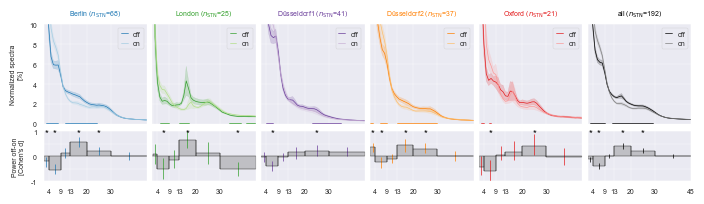

In [8]:
kind = 'normalized'
paired = True
if kind == 'normalized':
    df = dataframes['df_norm']
    psd = 'psd'
    freqs = 'psd_freqs'
    fm_params = False
    projects = cfg.PROJECT_ORDER_SLIM
    palette = None

if scale == 'log':
    psd += '_log'

hue = 'cond'
n_cols = len(projects)
n_rows = 2
fig_x_size = 7 if n_cols > 1 else 1.5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_x_size, 2),
                            sharex="col", sharey="row",
                            height_ratios=[3, 1.5])
axes = _axes2d(axes, n_rows, n_cols)
for i, proj in enumerate(projects):
    df_proj = df[df.project == proj]
    if paired:
        # smaller sample size but stronger statistics
        df_proj, n_sample = equalize_x_and_y(df_proj, 'cond', psd)
    else:
        n_sample = df_proj.subject.nunique()
    bands = False
    ax = axes[0, i]
    df_proj, hue_order = _mean_psds_ax(ax, df_proj, freqs, psd, kind, hue,
                                       paired=paired, fm_params=fm_params,
                  n_perm=n_perm, add_bands=bands, scale=scale, palette=palette)
    ax = axes[1, i]
    ylabel = True if i == 0 else False
    _forrest_plot_ax(ax, df_proj, kind, hue, estimator=estimator,
                     hue_order=hue_order,
                              paired=paired, n_boot=n_boot, ylabel=ylabel,
                              add_band_colors=bands, scale=scale,
                              palette=palette)
    sample_size_str = f' ({cfg.SAMPLE_STN}='f"{n_sample})"
    axes[0, i].set_title(cfg.PROJECT_DICT[proj] + sample_size_str,
                         color=cfg.COLOR_DIC[proj])
if tight_layout:
    plt.tight_layout()
plt.subplots_adjust(hspace=0.1, wspace=0.05)
fig_name = f'PSDs_forrest_plot_{estimator}_{kind}_{scale}_paired={paired}'
# _save_fig(fig, join(KIND_DIR[kind], ch_choice, fig_name), SAVE_DIR,
#             close=False, transparent=False, bbox_inches=bbox_inches)

# Absolute and periodic kind comparison

Sammple size:  ($n_{\text{STN}}$=192)


all clusters:

Enhanced:
3-9 Hz


Reduced:
13-17 Hz


all effect_size:

delta: -0.17
theta: -0.26
alpha: -0.02
beta_low: 0.15
beta_high: 0.02
gamma_low: -0.03


/var/folders/1y/49sjn_6j1_sgl474yd2zw6pc0000gn/T/ipykernel_78393/95923533.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Severe patients (n=57)', NaN, 'Mild patients (n=62)', 'Mild patients (n=62)', 'Mild patients (n=62)', ..., 'Severe patients (n=57)', 'Severe patients (n=57)', 'Severe patients (n=57)', 'Mild patients (n=62)', 'Mild patients (n=62)']
Length: 125
Categories (2, object): ['Mild patients (n=62)' < 'Severe patients (n=57)']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  df_proj.loc[:, hue] = df_proj[hue].cat.rename_categories(rename)




all clusters:

Enhanced:


Reduced:


all effect_size:

delta: 0.00
theta: -0.26
alpha: -0.15
beta_low: 0.23
beta_high: -0.13
gamma_low: -0.15
Sammple size:  ($n_{\text{STN}}$=179)


all clusters:

Enhanced:
2-8 Hz
37-45 Hz


Reduced:
12-17 Hz


all effect_size:

delta: -0.17
theta: -0.28
alpha: 0.08
beta_low: 0.18
beta_high: 0.03
gamma_low: -0.04


/var/folders/1y/49sjn_6j1_sgl474yd2zw6pc0000gn/T/ipykernel_78393/95923533.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Severe patients (n=56)', NaN, 'Mild patients (n=59)', 'Mild patients (n=59)', 'Mild patients (n=59)', ..., 'Severe patients (n=56)', 'Severe patients (n=56)', 'Severe patients (n=56)', 'Mild patients (n=59)', 'Mild patients (n=59)']
Length: 121
Categories (2, object): ['Mild patients (n=59)' < 'Severe patients (n=56)']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  df_proj.loc[:, hue] = df_proj[hue].cat.rename_categories(rename)




all clusters:

Enhanced:


Reduced:
27-33 Hz


all effect_size:

delta: -0.21
theta: -0.29
alpha: -0.06
beta_low: 0.27
beta_high: -0.14
gamma_low: -0.16


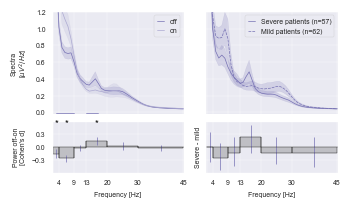

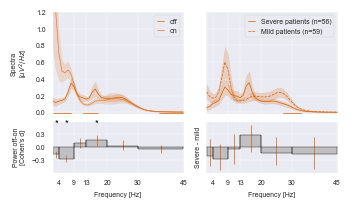

In [9]:
hues = ['cond', 'UPDRS_III_severity_median']
proj = 'all'
n_cols = len(hues)
n_rows = 2
fig_x_size = 3.5
bands = False

kinds = ['absolute', 'periodic']


for kind in kinds:
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_x_size, 2),
                            sharex="col", sharey="row",
                            height_ratios=[3, 1.5])
    axes = _axes2d(axes, n_rows, n_cols)
    for col, hue in enumerate(hues):
        if hue == 'cond':
            paired = True
            conds = ['off', 'on']
        elif hue.endswith('_severity_median'):
            conds = ['off']
            paired = False
        if conds == ['off']:
            palette = [cfg.COLOR_DIC[kind], cfg.COLOR_DIC[kind]]
        elif conds == ['on']:
            palette = [cfg.COLOR_DIC[kind + '2'], cfg.COLOR_DIC[kind + '2']]
        elif conds == ['off', 'on']:
            palette = [cfg.COLOR_DIC[kind], cfg.COLOR_DIC[kind + '2']]
        else:
            palette = None
        if kind == 'absolute':
            df_proj = dataframes['df_abs']
            psd = 'psd'
            df_proj = df_proj[(df_proj.project == proj) & (df_proj.cond.isin(conds))]
            if paired:
                # smaller sample size but stronger statistics
                df_proj, n_sample = equalize_x_and_y(df_proj, hue, psd)
                sample_size_str = f' ({cfg.SAMPLE_STN}='f"{n_sample})"
            else:
                n_sample = df_proj.subject.nunique()
                sample_size_str = f' ({cfg.SAMPLE_PAT}='f"{n_sample})"
            freqs = 'psd_freqs'
            fm_params = df_proj.fm_params.unique()
        elif kind == 'periodic':
            df_proj = dataframes['df_per']
            df_proj = df_proj[(df_proj.project == proj) & (df_proj.cond.isin(conds))]
            if paired:
                # smaller sample size but stronger statistics
                df_proj, n_sample = equalize_x_and_y(df_proj, hue, psd)
                sample_size_str = f' ({cfg.SAMPLE_STN}='f"{n_sample})"
            else:
                n = df_proj.subject.nunique()
                sample_size_str = f' ({cfg.SAMPLE_PAT}='f"{n_sample})"
            psd = 'fm_psd_peak_fit'
            freqs = 'fm_freqs'
            fm_params = df_proj.fm_params.unique()
        else:
            raise ValueError(f'Unknown kind {kind}')

        if scale == 'log':
            psd += '_log'

        ax = axes[0, col]
        if hue == 'cond':
            print(f'Sammple size: {sample_size_str}')
        df_proj, hue_order = _mean_psds_ax(ax, df_proj, freqs, psd, kind, hue,
                                paired=paired, n_perm=n_perm, add_bands=bands,
                                scale=scale, palette=palette)
        ax = axes[1, col]
        _forrest_plot_ax(ax, df_proj, kind, hue, estimator=estimator, paired=paired,
                         hue_order=hue_order,
                        n_boot=n_boot, add_band_colors=bands, scale=scale,
                        palette=palette)
        ax.set_xlabel('Frequency [Hz]')
    if tight_layout:
        plt.tight_layout()
    plt.subplots_adjust(hspace=0.1, wspace=None)
    fig_name = f'PSDs_forrest_plot_{estimator}_{kind}_{scale}_{'_'.join(hues)}'
    _save_fig(fig, join('Figure2', ch_choice, fig_name), SAVE_DIR,
                close=False, transparent=False, bbox_inches=bbox_inches)

# Absolute dataset comparison



Berlin clusters:

Enhanced:
3-9 Hz
40-44 Hz


Reduced:
13-17 Hz


Berlin effect_size:

delta: -0.28
theta: -0.37
alpha: -0.05
beta_low: 0.11
beta_high: -0.04
gamma_low: -0.07


London clusters:

Enhanced:


Reduced:
12-17 Hz


London effect_size:

delta: 0.19
theta: -0.13
alpha: 0.24
beta_low: 0.38
beta_high: 0.28
gamma_low: 0.21


Düsseldorf1 clusters:

Enhanced:


Reduced:
22-25 Hz


Düsseldorf1 effect_size:

delta: 0.06
theta: -0.11
alpha: 0.01
beta_low: 0.06
beta_high: 0.10
gamma_low: 0.09


Düsseldorf2 clusters:

Enhanced:
6-9 Hz


Reduced:
2-3 Hz
12-31 Hz


Düsseldorf2 effect_size:

delta: 0.15
theta: -0.15
alpha: -0.06
beta_low: 0.39
beta_high: 0.32
gamma_low: 0.11


Oxford clusters:

Enhanced:
6-7 Hz
32-42 Hz
44-45 Hz


Reduced:


Oxford effect_size:

delta: -0.33
theta: -0.42
alpha: -0.03
beta_low: 0.12
beta_high: 0.05
gamma_low: -0.36


all clusters:

Enhanced:
3-9 Hz


Reduced:
13-17 Hz


all effect_size:

delta: -0.17
theta: -0.26
alpha: -0.02
beta_low: 0.15
beta_high: 0.

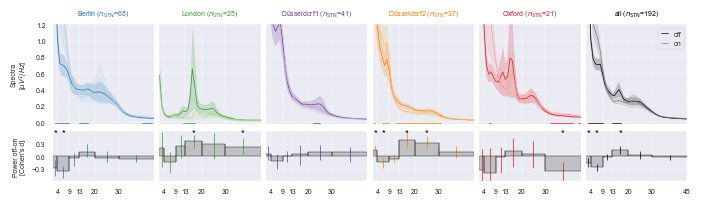

In [10]:
kind = 'absolute'
paired = True

df = dataframes['df_abs']
psd = 'psd'
freqs = 'psd_freqs'
fm_params = 'broad'
projects = cfg.PROJECT_ORDER_SLIM
palette = None

if scale == 'log':
    psd += '_log'

hue = 'cond'
n_cols = len(projects)
n_rows = 2
fig_x_size = 7 if n_cols > 1 else 1.5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_x_size, 2),
                            sharex="col", sharey="row",
                            height_ratios=[3, 1.5])
axes = _axes2d(axes, n_rows, n_cols)
for i, proj in enumerate(projects):
    df_proj = df[df.project == proj]
    if paired:
        # smaller sample size but stronger statistics
        df_proj, n_sample = equalize_x_and_y(df_proj, 'cond', psd)
    else:
        n_sample = df_proj.subject.nunique()
    bands = False
    ax = axes[0, i]
    df_proj, hue_order = _mean_psds_ax(ax, df_proj, freqs, psd, kind, hue, paired=paired,
                  fm_params=fm_params,
                  n_perm=n_perm, add_bands=bands, scale=scale, palette=palette)
    ax = axes[1, i]
    ylabel = True if i == 0 else False
    _forrest_plot_ax(ax, df_proj, kind, hue, estimator=estimator,
                     hue_order=hue_order,
                              paired=paired, n_boot=n_boot, ylabel=ylabel,
                              add_band_colors=bands, scale=scale,
                              palette=palette)
    sample_size_str = f' ({cfg.SAMPLE_STN}='f"{n_sample})"
    axes[0, i].set_title(cfg.PROJECT_DICT[proj] + sample_size_str,
                         color=cfg.COLOR_DIC[proj])
if tight_layout:
    plt.tight_layout()
plt.subplots_adjust(hspace=0.1, wspace=0.05)
fig_name = f'PSDs_forrest_plot_{estimator}_{kind}_{scale}_paired={paired}'
_save_fig(fig, join('Figure1', ch_choice, fig_name), SAVE_DIR,
            close=False, transparent=False, bbox_inches=bbox_inches)

In [11]:
1/0

ZeroDivisionError: division by zero

# Plotting aperiodic component boring because no off-on differences visibile

### Important: 'fm_psd_peak_fit' and '10**fm_psd_peak_fit_log' and 'fm_psd_peak_fit_log' are all different...

### -> fm_psd_peak_fit makes the most sense because correct units
### -> fm_psd_peak_fit_log not optimal for stats/plotting because mean of log values not the same as log of mean

-> 10**fm_psd_peak_fit_log does not make sense. Cannot convert partial log value to linear value if aperiodic missing. log10(8+2) is not log(8) + log(2).

-> why does log10(fm_psd_peak_fit) give the correct linear units and not fm_psd_peak_fit? Shouldn't fm_psd_peak_fit be linear already?

In [ ]:
freq = 40

print(f'PSD at {freq} Hz: {df_abs.psd.values[0][df_abs.psd_freqs.iloc[0] == freq][0]:.2f} µV²/Hz')
print(f'fm peak at {freq} Hz: {df_abs.fm_psd_peak_fit.values[0][df_abs.fm_freqs.iloc[0] == freq][0]:.2f} µV²/Hz')
print(f'fm ap at {freq} Hz: {df_abs.fm_psd_ap_fit.values[0][df_abs.fm_freqs.iloc[0] == freq][0]:.2f} µV²/Hz')
print(f'fm full at {freq} Hz: {df_abs.fm_fooofed_spectrum.values[0][df_abs.fm_freqs.iloc[0] == freq][0]:.2f} µV²/Hz')
print(f'fm peak+ap at {freq} Hz: {df_abs.fm_psd_peak_fit.values[0][df_abs.fm_freqs.iloc[0] == freq][0] + df_abs.fm_psd_ap_fit.values[0][df_abs.fm_freqs.iloc[0] == freq][0]:.2f} µV²/Hz')
print(f'fm fooofed - ap at {freq} Hz: {df_abs.fm_fooofed_spectrum.values[0][df_abs.fm_freqs.iloc[0] == freq][0] - df_abs.fm_psd_ap_fit.values[0][df_abs.fm_freqs.iloc[0] == freq][0]:.2f} µV²/Hz')

PSD at 40 Hz: 0.03 µV²/Hz
fm peak at 40 Hz: 0.00 µV²/Hz
fm ap at 40 Hz: 0.03 µV²/Hz
fm full at 40 Hz: 0.03 µV²/Hz
fm peak+ap at 40 Hz: 0.03 µV²/Hz
fm fooofed - ap at 40 Hz: 0.00 µV²/Hz


/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_pl

Text(0.5, 1.05, "'fm_psd_peak_fit_log' and '10**fm_psd_peak_fit_log' and 'fm_psd_peak_fit' are all different...")

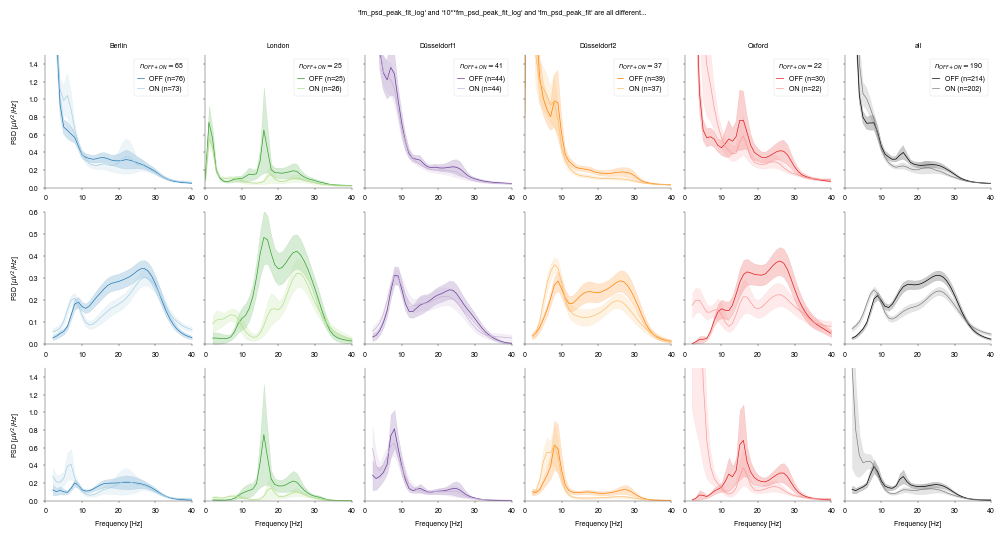

In [ ]:
plot_x = ['psd_freqs', 'fm_freqs', 'fm_freqs']
plot_y = ['psd', 'fm_psd_peak_fit_log', 'fm_psd_peak_fit']
xlabels = [False, False, True]
titles = [True, False, False]
# log = [False, False, False, False, True]
ylims = [(0, 1.5), (0, 0.6), (0, 1.5)]

fig, axes = plt.subplots(nrows=3, ncols=n_cols, figsize=(10, 5), sharey='row')
for row_idx in range(3):
    df_proj = df_abs.copy()
    fm_params = df_proj.fm_params.unique()
    x = plot_x[row_idx]
    y = plot_y[row_idx]
    # if log[row_idx]:
    #     df_plot[y] = 10**df_plot[y]
    df_psd = explode_df(df_proj, psd=y, fm_params=fm_params, freqs=x,
                          keep_cols='fm_params')
    xmask = (df_psd[x] <= xlim[1])
    df_psd = df_psd.loc[xmask]
    for col_idx, project in enumerate(projects):
        df_psd_proj = df_psd[df_psd.project == project]
        proj = projects[col_idx]
        _mean_psds_ax(axes, df_psd_proj, x, y, proj, hue_order, row_idx, col_idx,
               legend=titles[row_idx], proj_titles=titles[row_idx],
               add_bands=False, ylim=ylims[row_idx],
               xlim=xlim, xlabel=xlabels[row_idx], xticklabels=True)
plt.tight_layout()
plt.suptitle("'fm_psd_peak_fit_log' and '10**fm_psd_peak_fit_log' and 'fm_psd_peak_fit' are all different...", y=1.05)